## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from problems import problem_GC

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

visualizing p(x|theta)


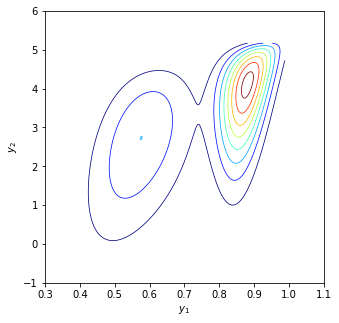

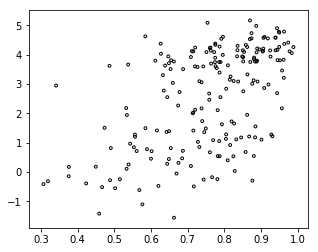

In [2]:
DIR = 'results/GC'                                             
RERUN = not utils_os.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GC.Gaussian_Copula_Problem(N=500, n=200)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed stat
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
    
    # collect samples
    true_samples = problem.sample_from_true_posterior()
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Visualize the problem
problem.visualize()
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)

In [5]:
snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
# snl2_abc.run()
theta = snl2_abc.prior()
data = snl2_abc.problem.simulator(theta)
y = snl2_abc.problem.statistics(data=data, theta=theta)
print(theta.shape,data.shape, problem.y_obs.shape)
snl2_abc._simulate([50,200,0])

(3,) (200, 2) (1, 41)
[ABC] sub-process start!
[sampling] finished sampling  10
[sampling] finished sampling  20
[sampling] finished sampling  30
[sampling] finished sampling  40


[array([[2.21726671e+00, 9.30855379e-01, 4.93398970e-01],
        [7.01768933e+00, 4.29866771e-01, 5.01235641e-01],
        [6.88559195e+00, 9.34955018e-01, 7.11115931e-01],
        [6.76905264e+00, 3.52987014e-01, 4.55638870e-01],
        [2.83488437e+00, 7.53595534e-01, 7.50479590e-01],
        [1.17704194e+01, 6.14692226e-01, 4.72766284e-01],
        [7.86487280e+00, 1.96455008e-01, 6.64897094e-01],
        [4.03562905e+00, 6.09274136e-01, 4.73186136e-01],
        [5.98169901e+00, 8.97051638e-01, 7.07654378e-01],
        [1.11793571e+01, 8.29920337e-01, 4.80201400e-01],
        [1.15747175e+01, 8.95481695e-01, 4.27871805e-01],
        [1.05441120e+01, 2.21426768e-01, 7.57638152e-01],
        [1.00421409e+01, 4.91846247e-01, 4.21108948e-01],
        [1.49845894e+00, 9.14162251e-01, 4.55344574e-01],
        [5.84418210e+00, 1.26410401e-01, 4.99218416e-01],
        [8.39212447e+00, 7.74593890e-01, 5.23697933e-01],
        [8.78275557e+00, 8.05712825e-01, 7.98437949e-01],
        [9.062

## Inference

### SMC

iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start![ABC] sub-process start!
[ABC] sub-process start!


[sampling] finished sampling  20
[sampling] finished sampling  40
[sampling] finished sampling  60
[sampling] finished sampling  80
> learning fake posterior 
> learning true posterior 


iteration  1
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start![ABC] sub-process start!

[sampling] finished sampling  20
[sampling] finished sampling  40
[sampling] finished sampling  60
[sampling] finished sampling  80
> learning fake posterior 
> learning true posterior 


iteration  2
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  20
[sampling] finished sampling  40
[sampling] finished sampling  60
[sampling] finished sampling  80
> learning fake posterior 
> learning true posterior 


iteration  3
# of cpus =  4
[ABC] sub-process start!

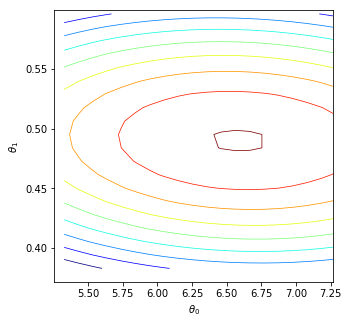

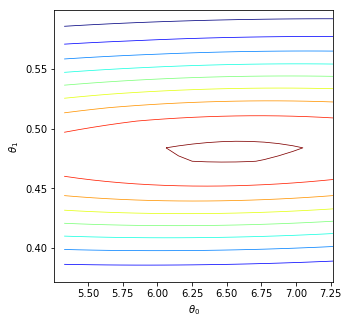

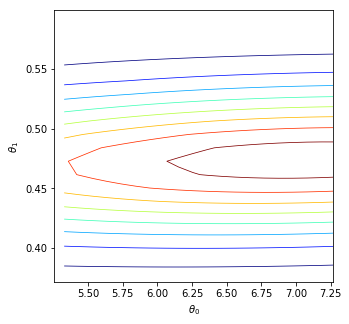

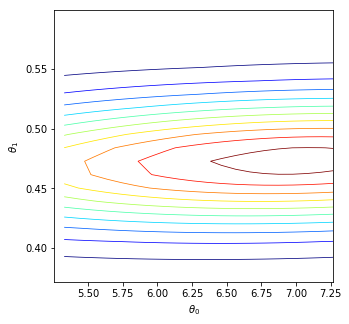

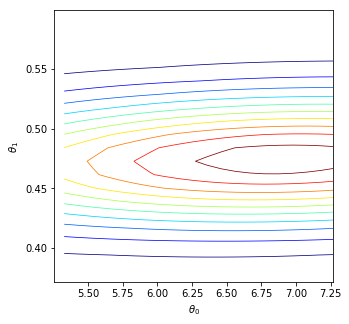

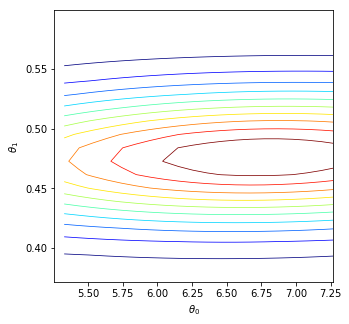

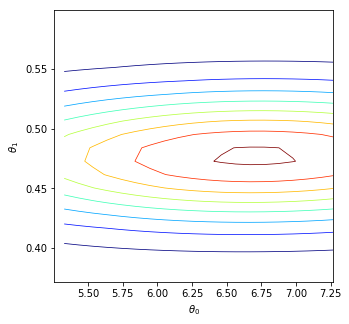

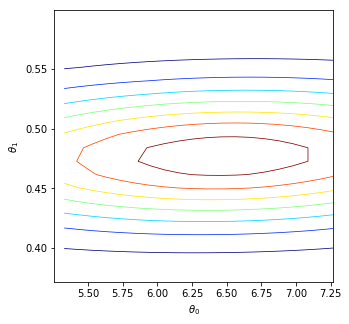

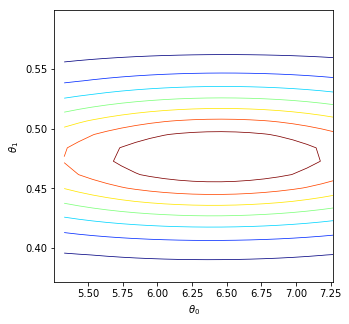

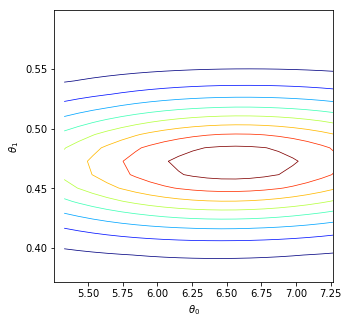

In [16]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 10                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC', JSD_smc_array)

In [14]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 1000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 10                                # number of learning rounds
hyperparams.hidden_ratio = 0.20                  # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.estimator = 'JSD'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start![ABC] sub-process start![ABC] sub-process start!



[sampling] finished sampling  5
[sampling] finished sampling  10
[sampling] finished sampling  15
[sampling] finished sampling  20

 > fitting encoder
summary statistic dim = 8 original dim = 41
architecture [41, 100, 100, 8]
validation size= 0.8
finished: t= 0 loss= 1.3866132497787476 loss val= 1.3865330219268799 time= 0.04472184181213379
finished: t= 50 loss= 1.3766469955444336 loss val= 1.375450849533081 time= 0.03407907485961914
finished: t= 100 loss= 1.343383550643921 loss val= 1.33588445186615 time= 0.03352761268615723
finished: t= 150 loss= 1.243889331817627 loss val= 1.2204452753067017 time= 0.032896995544433594
finished: t= 200 loss= 1.0915400981903076 loss val= 1.0451828241348267 time= 0.03291749954223633
finished: t= 250 loss= 0.9691085815429688 loss val= 0.9452787637710571 time= 0.034842491149902344
finished: t= 300 loss= 0.8840461373329163 loss va

IndexError: index 100 is out of bounds for axis 0 with size 100

### SNL


 SNL ABC
iteration  0
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start![ABC] sub-process start![ABC] sub-process start!



[sampling] finished sampling  5
[sampling] finished sampling  10
[sampling] finished sampling  15
[sampling] finished sampling  20
finished: t= 0 loss= 181.25814819335938 loss val= 138.92442321777344
finished: t= 500 loss= -67.86775207519531 loss val= -54.45940017700195
best val loss= -55.81486892700195


iteration  1
# of cpus =  4
[ABC] sub-process start![ABC] sub-process start!

[ABC] sub-process start!
[ABC] sub-process start!
[sampling] finished sampling  5
[sampling] finished sampling  10
[sampling] finished sampling  15
[sampling] finished sampling  20
finished: t= 0 loss= 151.42640686035156 loss val= 139.73269653320312
finished: t= 500 loss= -68.79669189453125 loss val= -62.0664176940918
best val loss= -66.80596923828125


iteration  2
# of cpus =  4
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process start!
[ABC] sub-process 

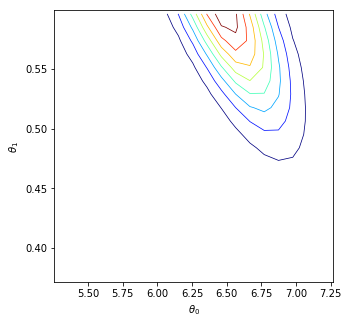

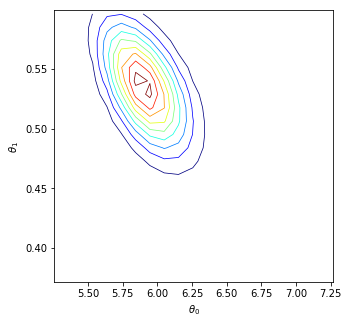

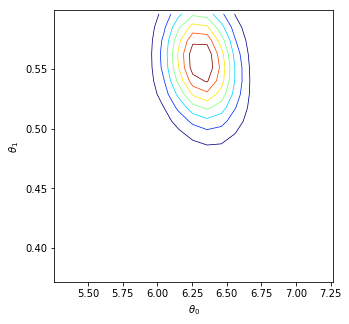

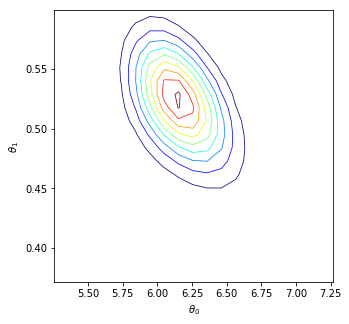

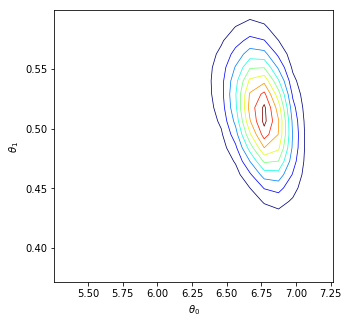

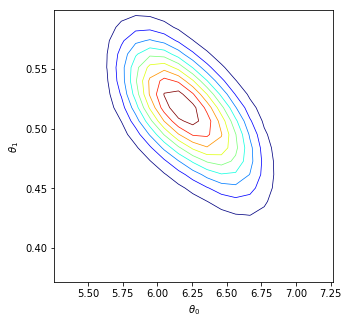

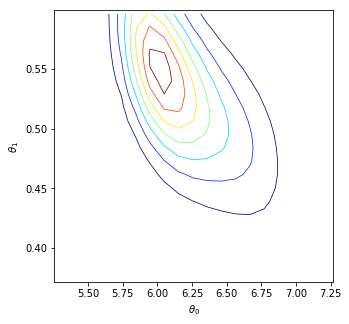

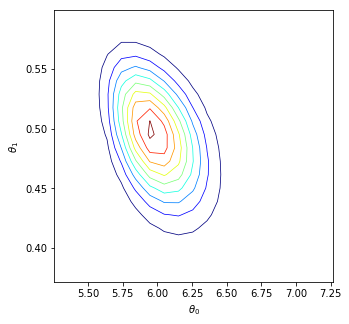

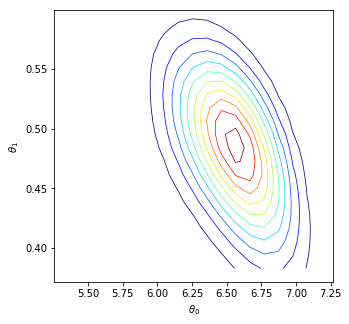

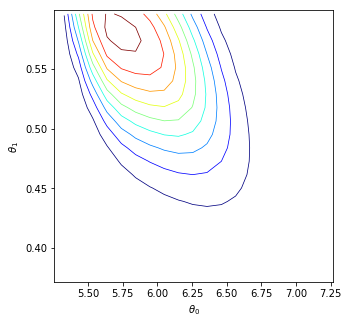

In [7]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 1000
hyperparams.L = 10

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL', JSD_array)

In [3]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 1000                       # number of simulations
hyperparams.L = 10                               # number of learning rounds
hyperparams.hidden_ratio = 0.15                  # dimensionality of S(x)
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.estimator = 'DC'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
# snl2_abc.run()

# JSD_array = []
# for l in range(len(snl2_abc.nde_array)):
#     print('l=', l)
#     snl2_abc.set(l=l)
#     visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
#     JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
#     JSD_array.append(JSD)
#     print('JSD snl+ = ', JSD)
# utils_os.save_object(DIR, 'JSD_SNL2', JSD_array)